# Instrumental analysis

In [1]:
library(readr)
library(dplyr, warn.conflicts = FALSE)
library(tidyr, warn.conflicts = FALSE)
library(purrr)
library(ggplot2)

## SNPs in the reference panel

Calculating MAF:

In [85]:
paste(
    "/ludc/Tools/Software/Plink/2.3_alpha_final/plink2",
    "--bfile /ludc/Home/daniel_c/projects/DVA/Data/ReferenceData/1kg_ref/EUR",
    "--freq cols=chrom,pos,ref,alt,altfreq",
    "--out /ludc/Home/daniel_c/projects/DVA/Data/ReferenceData/1kg"
) %>%
    system

Importing results:

In [2]:
freq_1kg <- read_tsv("~/projects/DVA/Data/ReferenceData/1kg.afreq",
                     skip = 1,
                     col_names = c("chr", "position", "rsid", "nea_1kg_plus", "ea_1kg_plus", "eaf_1kg"),
                     col_types = "nncccn")

In [3]:
head(freq_1kg)

chr,position,rsid,nea_1kg_plus,ea_1kg_plus,eaf_1kg
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
1,11008,rs575272151,C,G,0.0884692
1,11012,rs544419019,C,G,0.0884692
1,13110,rs540538026,G,A,0.0566600
1,13116,rs62635286,T,G,0.1868790
1,13118,rs200579949,A,G,0.1868790
1,13273,rs531730856,G,C,0.1471170


## Outcome data - T2D

In [4]:
outcome_data <- read_tsv(
    pipe("sed 's/:/\t/g' ~/projects/DVA/Data/GWAS_sumstats/t2d_diagram.txt"),
    skip = 1,
    col_names = c("chr", "position", 
                  paste(c("ea", "nea", "beta", "se", "p", "n"), "t2d", sep = "_")),
    col_types = "nnccnnnn"
)
head(outcome_data)

chr,position,ea_t2d,nea_t2d,beta_t2d,se_t2d,p_t2d,n_t2d
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
5,85928892,T,C,-0.0130,0.026,0.61,158186
11,107819621,A,C,-0.0710,0.170,0.67,124696
10,128341232,T,C,0.0140,0.012,0.24,158186
1,209652100,T,C,0.1500,0.130,0.25,131539
18,51112281,T,C,-0.0085,0.013,0.53,158184
4,55643311,T,C,-0.0060,0.016,0.71,158185


In [5]:
outcome_data <- outcome_data %>%
    inner_join(freq_1kg, by = c("chr", "position")) %>%
    mutate(
        ea_1kg_minus = stringr::str_replace_all(ea_1kg_plus, c("A" = "t", "T" = "a", "C" = "g", "G" = "c")),
        ea_1kg_minus = toupper(ea_1kg_minus),
        nea_1kg_minus = stringr::str_replace_all(nea_1kg_plus, c("A" = "t", "T" = "a", "C" = "g", "G" = "c")),
        nea_1kg_minus = toupper(nea_1kg_minus),
        harmon = case_when(ea_t2d == ea_1kg_plus & nea_t2d == nea_1kg_plus ~ 1,
                           ea_t2d == ea_1kg_minus & nea_t2d == nea_1kg_minus ~ 1,
                           ea_t2d == nea_1kg_plus & nea_t2d == ea_1kg_plus ~ -1,
                           ea_t2d == nea_1kg_minus & nea_t2d == ea_1kg_minus ~ -1,
                           TRUE ~ 0)
    ) %>%
    filter(harmon != 0) %>%
    select(-c(harmon, ea_1kg_plus, ea_1kg_minus, nea_1kg_plus, nea_1kg_minus)) %>%
    # Ambiguous palindromic SNPs
    mutate(maf_1kg = ifelse(eaf_1kg < .5, eaf_1kg, 1 - eaf_1kg),
           palind_1 = ea_t2d %in% c("A", "T") & nea_t2d %in% c("A", "T"),
           palind_2 = ea_t2d %in% c("C", "G") & nea_t2d %in% c("C", "G"),
           palind_ambig = (palind_1 | palind_2) & maf_1kg > .4) %>%
    filter(!palind_ambig) %>%
    select(-starts_with("palind"), -eaf_1kg)
head(outcome_data)

chr,position,ea_t2d,nea_t2d,beta_t2d,se_t2d,p_t2d,n_t2d,rsid,maf_1kg
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
5,85928892,T,C,-0.0130,0.026,0.61,158186,rs113534962,0.0626243
10,128341232,T,C,0.0140,0.012,0.24,158186,rs2366866,0.4592450
18,51112281,T,C,-0.0085,0.013,0.53,158184,rs62099898,0.2624250
4,55643311,T,C,-0.0060,0.016,0.71,158185,rs11725240,0.1640160
1,4429872,T,G,-0.0390,0.029,0.17,158184,rs72631092,0.0497018
5,58252088,A,C,-0.0080,0.016,0.62,158186,rs10069993,0.1590460


## Exposure data

### Traits identified in profile comparison

In [6]:
exposures_tab <- tibble::tribble(
    ~trait_short, ~id,
    "Urate", "ukb-d-30880_irnt",
    "WHR", "ieu-a-73",
    "#Leuco", "ukb-d-30000_irnt",
    "SBP", "ieu-b-38",
    "DBP", "ieu-b-39",
    "HDL", "ukb-d-30760_irnt",
    "LDL", "ukb-d-30780_irnt",
    "TG", "ukb-d-30870_irnt",
    "HeelBMD", "ukb-b-20124",
    "Phosphate", "ukb-d-30810_irnt",
    "Platelet volume", "ukb-d-30100_irnt",
    "Urea", "ukb-d-30670_irnt",
    "MCV", "ukb-d-30040_irnt",
    "MCH", "ukb-d-30050_irnt",
    "EDW", "ukb-d-30070_irnt",
    "MCHC", "ukb-d-30060_irnt"
)

In [7]:
sigins <- read_tsv(
    "../data/sigins.tsv", 
    col_types = "nnnnnnccccnc"
) %>%
    inner_join(exposures_tab) %>%
    inner_join(outcome_data) %>%
    mutate(
        ea_exp = ifelse(beta > 0, ea, nea),
        nea_exp = ifelse(beta > 0, nea, ea),
        eaf_exp = ifelse(beta > 0, eaf, 1 - eaf),
        maf_exp = ifelse(eaf_exp > .5, 1 - eaf_exp, eaf_exp),
        zscore = beta / se,
        se_exp = 1/sqrt(2 * maf_exp * (1 - maf_exp) * (n + (zscore^2))),
        beta_exp = abs(zscore * se),
        ea_flip = stringr::str_replace_all(ea_exp, c("A" = "t", "T" = "a", "C" = "g", "G" = "c")),
        nea_flip = stringr::str_replace_all(nea_exp, c("A" = "t", "T" = "a", "C" = "g", "G" = "c")),
        harmon = case_when(ea_exp == ea_t2d & nea_exp == nea_t2d ~ 1,
                           ea_exp == nea_t2d & nea_exp == ea_t2d ~ -1,
                           ea_flip == ea_t2d & nea_flip == nea_t2d ~ 1,
                           ea_flip == nea_t2d & nea_flip == ea_t2d ~ -1,
                           TRUE ~ 0),
        beta_t2d = beta_t2d * harmon
    ) %>%
    filter(harmon != 0, abs(maf_exp - maf_1kg) < .2) %>%
    select(-c(ea, nea, eaf, ea_flip, nea_flip, ea_t2d, nea_t2d, harmon, beta, se, zscore)) %>%
    rename(p_exp = p, n_exp = n) %>%
    select(chr, position, rsid, maf_1kg, ea_exp, nea_exp, eaf_exp, maf_exp, 
           trait, trait_short, id,
           all_of(c(paste(c("beta", "se", "p", "n"), "exp", sep = "_"),
                    paste(c("beta", "se", "p", "n"), "t2d", sep = "_"))))
head(sigins)

Warning message:
"One or more parsing issues, see `problems()` for details"
Joining, by = "id"
Joining, by = c("position", "chr", "rsid")


chr,position,rsid,maf_1kg,ea_exp,nea_exp,eaf_exp,maf_exp,trait,trait_short,id,beta_exp,se_exp,p_exp,n_exp,beta_t2d,se_t2d,p_t2d,n_t2d
<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,54834360,rs7545834,0.148111,G,T,0.14459,0.14459,Urea,Urea,ukb-d-30670_irnt,0.018498,0.003427652,1.81811e-08,344052,-0.0200,0.018,0.27,158184
1,54844688,rs12022510,0.107356,G,A,0.11123,0.11123,Urea,Urea,ukb-d-30670_irnt,0.022772,0.003833916,4.07878e-10,344052,-0.0250,0.020,0.22,158184
1,54848827,rs80020578,0.107356,A,G,0.10972,0.10972,Urea,Urea,ukb-d-30670_irnt,0.022626,0.003856940,7.60904e-10,344052,-0.0250,0.020,0.21,158184
1,67403787,rs2985821,0.263419,A,G,0.73466,0.26534,Urea,Urea,ukb-d-30670_irnt,0.027027,0.002729984,2.32809e-25,344052,-0.0048,0.013,0.72,158184
1,67443751,rs58680688,0.263419,C,G,0.73478,0.26522,Urea,Urea,ukb-d-30670_irnt,0.027111,0.002730376,1.68811e-25,344052,-0.0054,0.013,0.69,158184
1,82962840,rs2094323,0.354871,C,T,0.63322,0.36678,Urea,Urea,ukb-d-30670_irnt,0.017142,0.002501272,1.14262e-12,344052,-0.0120,0.013,0.36,158184


### BMI

In [9]:
bmi <- read_tsv(
    "~/projects/DVA/Data/GWAS_sumstats/bmi.txt", 
    skip = 1,
    col_names = c("chr", "position", "rsid", 
                  paste(c("ea", "nea", "eaf", "beta", "se", "pval", "n"), "bmi", sep = "_")),
    col_types = "nncccnnnnn"
)
head(bmi)

chr,position,rsid,ea_bmi,nea_bmi,eaf_bmi,beta_bmi,se_bmi,pval_bmi,n_bmi
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7,92383888,rs10,A,C,0.06431,0.0013,0.0042,0.7500,598895
12,126890980,rs1000000,A,G,0.22190,0.0001,0.0021,0.9600,689928
4,21618674,rs10000010,T,C,0.50860,-0.0001,0.0016,0.9400,785319
4,1357325,rs10000012,C,G,0.86340,0.0047,0.0025,0.0570,692463
4,37225069,rs10000013,A,C,0.77080,-0.0061,0.0021,0.0033,687856
4,84778125,rs10000017,T,C,0.22840,0.0041,0.0021,0.0480,686123


## Instruments: 
***- Significant for BMI and traits***

***- Aligned to the BMI increasing allele***

***- With data on T2D risk***

In [10]:
validins_bmi <- bmi %>%
    filter(pval_bmi < 5e-8) %>%
    mutate(maf_bmi = ifelse(eaf_bmi < .5, eaf_bmi, 1 - eaf_bmi),
           new_ea = ifelse(beta_bmi > 0, ea_bmi, nea_bmi),
           new_nea = ifelse(beta_bmi > 0, nea_bmi, ea_bmi),
           eaf_bmi = ifelse(beta_bmi > 0, eaf_bmi, 1 - eaf_bmi),
           beta_bmi = abs(beta_bmi)) %>%
    select(-c(ea_bmi, nea_bmi)) %>%
    inner_join(sigins, by = c("chr", "position", "rsid")) %>%
    filter(abs(maf_bmi - maf_1kg) < .2) %>%
    ## Aligning to the BMI increasing allele
    mutate(
        ea_flip = toupper(stringr::str_replace_all(new_ea, c("A" = "t", "T" = "a", "C" = "g", "G" = "c"))),
        nea_flip = toupper(stringr::str_replace_all(new_nea, c("A" = "t", "T" = "a", "C" = "g", "G" = "c"))),
        harmon = case_when(ea_exp == new_ea & nea_exp == new_nea ~ 1,
                           ea_exp == new_nea & nea_exp == new_ea ~ -1,
                           ea_flip == new_ea & nea_flip == new_nea ~ 1,
                           ea_flip == new_nea & nea_flip == new_ea ~ -1,
                           TRUE ~ 0),
        beta_exp = beta_exp * harmon,
        beta_t2d = beta_t2d * harmon,
        ea = new_ea, nea = new_nea
    ) %>%
    ## Removing SNPs with allele mismatch
    filter(harmon != 0, abs(maf_bmi - maf_1kg) < .2) %>%
    select(-c(harmon, new_ea, new_nea, ea_flip, nea_flip))
head(validins_bmi)

chr,position,rsid,eaf_bmi,beta_bmi,se_bmi,pval_bmi,n_bmi,maf_bmi,maf_1kg,⋯,beta_exp,se_exp,p_exp,n_exp,beta_t2d,se_t2d,p_t2d,n_t2d,ea,nea
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
4,38692835,rs1000096,0.6199,0.0144,0.0018,1.8e-15,656860,0.3801,0.328032,⋯,-0.0137272,0.002433478,1.70298e-08,350472,-0.0170,0.013,0.17,158185,C,T
4,102158899,rs10004357,0.2529,0.0108,0.0020,3.5e-08,692394,0.2529,0.256461,⋯,-0.1191000,0.001863344,1.71700e-09,753546,0.0150,0.014,0.27,158185,G,T
4,38745482,rs10008032,0.4885,0.0104,0.0018,5.0e-09,666587,0.4885,0.456262,⋯,-0.0137353,0.002397507,9.55103e-09,350472,-0.0100,0.013,0.42,152598,C,T
4,38765720,rs10008492,0.3586,0.0101,0.0018,2.9e-08,690122,0.3586,0.434394,⋯,-0.0141878,0.002572490,3.16599e-08,350472,-0.0150,0.012,0.22,158185,T,C
17,5283252,rs1000940,0.2987,0.0154,0.0018,1.1e-17,794558,0.2987,0.348907,⋯,0.0187340,0.002604767,5.88031e-13,350470,0.0150,0.013,0.23,158182,G,A
4,103200577,rs10014145,0.3187,0.0113,0.0017,7.1e-11,793208,0.3187,0.325050,⋯,-0.0197690,0.002702625,6.45803e-16,315133,0.0052,0.014,0.71,152598,G,A


### Clumping to obtain independent instruments

In [8]:
clump_fx <- function(rsid, pval, 
                     plink = "/ludc/Tools/Software/Plink/v1.90b5.2/plink", 
                     bfile = "/ludc/Home/daniel_c/projects/DVA/Data/ReferenceData/1kg_ref/EUR",
                     clump_p = 5e-8, clump_kb = 500, clump_r2 = 0.01){
    fn <- tempfile()
    dat <- data.frame(SNP = rsid, P = pval)
    write_tsv(dat, fn)
    plink_cmd <- paste0(plink,
                        " --bfile ", bfile,
                        " --clump ", fn, 
                        " --clump-p1 ", clump_p, 
                        " --clump-r2 ", clump_r2,
                        " --clump-kb ", clump_kb, 
                        " --out ", fn)
    system(plink_cmd)
    clumped_snps <- paste("awk '{print $3}'", paste(fn, "clumped", sep = ".")) %>%
        pipe %>%
        readLines
    unlink(paste0(fn, "*"))
    return(clumped_snps)
}

In [11]:
instr_clinpheno <- validins_bmi %>%
    group_by(trait_short) %>%
    group_modify(~{
        snps_to_retain <- clump_fx(.x$rsid, .x$p_exp)
        clumped_dat <- filter(.x, rsid %in% snps_to_retain)
    }) %>%
    ungroup
head(instr_clinpheno)

trait_short,chr,position,rsid,eaf_bmi,beta_bmi,se_bmi,pval_bmi,n_bmi,maf_bmi,⋯,beta_exp,se_exp,p_exp,n_exp,beta_t2d,se_t2d,p_t2d,n_t2d,ea,nea
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
#Leuco,7,99036920,rs10215854,0.90885,0.0224,0.0030,6.3e-14,691756,0.09115,⋯,0.0298086,0.004136375,4.61955e-13,350470,0.0049,0.021,0.810,158184,G,A
#Leuco,7,44811223,rs10252662,0.53710,0.0099,0.0017,1.1e-08,684183,0.46290,⋯,0.0189112,0.002401555,2.90469e-15,350470,0.0290,0.012,0.015,158184,C,T
#Leuco,2,211540507,rs1047891,0.32180,0.0141,0.0018,2.0e-15,774027,0.32180,⋯,-0.0168962,0.002569415,4.10110e-11,350470,-0.0012,0.014,0.930,158186,A,C
#Leuco,6,26031811,rs10484435,0.09454,0.0150,0.0026,1.0e-08,786653,0.09454,⋯,-0.0385525,0.003677915,6.99037e-26,350470,0.0086,0.022,0.700,152598,G,T
#Leuco,10,99025611,rs10882884,0.41310,0.0099,0.0018,1.8e-08,689381,0.41310,⋯,-0.0378099,0.002436051,1.50072e-54,350470,0.0290,0.012,0.020,158186,T,A
#Leuco,12,112610714,rs11066188,0.58190,0.0120,0.0017,8.1e-13,792755,0.41810,⋯,-0.0512590,0.002430258,3.73422e-99,350470,-0.0150,0.013,0.260,158183,G,A


## Stratifying instruments by sign of coefficient for trait and obtaining pooled estimate for each strata

In [23]:
instr_clinpheno_res <- instr_clinpheno %>%
    group_by(trait_short, sign_exp = sign(beta_exp)) %>%
    group_modify(
        ~{
            res <- meta::metagen(TE = beta_t2d, seTE = se_t2d, data = .x,
                                 fixed = FALSE, random = TRUE,
                                 method.tau = "PM", prediction = FALSE)
            with(res,
                 data.frame(b_meta = TE.random, se_meta = seTE.random,
                            conf_low_meta = lower.random, conf_high_meta = upper.random,
                            p_meta = pval.random, Qv = Q, Qdf = df.Q, Qp = pval.Q, Tau = tau, nsnp = nrow(.x)))
        }
    ) %>%
    ungroup
instr_clinpheno_res

trait_short,sign_exp,b_meta,se_meta,conf_low_meta,conf_high_meta,p_meta,Qv,Qdf,Qp,Tau,nsnp
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>
#Leuco,-1,-0.0005176567,0.004611261,-0.0095555613,0.008520248,9.106178e-01,82.86474920,30,7.591089e-07,0.02052323,31
#Leuco,1,0.0212152005,0.005804944,0.0098377192,0.032592682,2.575051e-04,124.12469464,26,9.367070e-15,0.02610202,27
DBP,-1,-0.0042547116,0.003357948,-0.0108361682,0.002326745,2.051349e-01,231.54581372,67,5.636943e-20,0.02328469,68
DBP,1,0.0120853549,0.003325093,0.0055682929,0.018602417,2.784210e-04,70.17414623,34,2.582244e-04,0.01402300,35
EDW,-1,0.0117780336,0.009148177,-0.0061520635,0.029708131,1.979294e-01,24.43639787,8,1.935675e-03,0.02265324,9
EDW,1,0.0171107597,0.006322499,0.0047188887,0.029502631,6.803173e-03,239.44257275,37,1.844740e-31,0.03591789,38
HDL,-1,0.0230991921,0.003436254,0.0163642590,0.029834125,1.789979e-11,179.85348112,54,1.933607e-15,0.02078928,55
HDL,1,-0.0124959843,0.010212399,-0.0325119183,0.007519950,2.210997e-01,118.62321534,19,2.005307e-16,0.04258720,20
HeelBMD,-1,-0.0018092298,0.005746985,-0.0130731129,0.009454653,7.529031e-01,63.97885605,18,4.584062e-07,0.02106042,19


In [32]:
write_tsv(instr_clinpheno_res, "../data/instr_clinpheno_res.tsv")

In [31]:
instr_clinpheno_res %>%
    transmute(trait_short, sign_exp = ifelse(sign_exp > 0, "Positive", "Negative"), 
              across(c(b_meta, conf_low_meta, conf_high_meta), format, digits = 2, decimal.mark = ","),
              p_meta = format(signif(p_meta, 3), decimal.mark = ","), nsnp) %>%
    pivot_wider(names_from = sign_exp, values_from = c(contains("meta"), nsnp)) %>%
    select(trait_short, contains("Positive"), contains("Negative")) %>%
    kableExtra::kbl("html", escape = FALSE,
                    col.names = c("Trait", rep(c("Beta", "Lower bound", "Upper bound", "<i>P</i>-value", "N SNPs"), 2))) %>%
    kableExtra::add_header_above(c(" " = 1, "High BMI - High trait" = 5, "High BMI - Low trait" = 5)) %>%
    as.character %>%
    IRdisplay::display_html()

High BMI - High trait 
 High BMI - Low trait 
 
 
 Trait 
 Beta 
 Lower bound 
 Upper bound 
 P -value 
 N SNPs 
 Beta 
 Lower bound 
 Upper bound 
 P -value 
 N SNPs 
 
 
 
 
 #Leuco 
 0,02122 
 0,00984 
 0,0326 
 2,58e-04 
 27 
 -0,00052 
 -0,00956 
 0,0085 
 9,11e-01 
 31 
 
 
 DBP 
 0,01209 
 0,00557 
 0,0186 
 2,78e-04 
 35 
 -0,00425 
 -0,01084 
 0,0023 
 2,05e-01 
 68 
 
 
 EDW 
 0,01711 
 0,00472 
 0,0295 
 6,80e-03 
 38 
 0,01178 
 -0,00615 
 0,0297 
 1,98e-01 
 9 
 
 
 HDL 
 -0,01250 
 -0,03251 
 0,0075 
 2,21e-01 
 20 
 0,02310 
 0,01636 
 0,0298 
 1,79e-11 
 55 
 
 
 HeelBMD 
 0,01857 
 0,01080 
 0,0263 
 2,80e-06 
 34 
 -0,00181 
 -0,01307 
 0,0095 
 7,53e-01 
 19 
 
 
 LDL 
 -0,00419 
 -0,01556 
 0,0072 
 4,70e-01 
 14 
 0,01776 
 -0,00046 
 0,0360 
 5,61e-02 
 18 
 
 
 MCH 
 0,00495 
 -0,00425 
 0,0142 
 2,92e-01 
 27 
 0,01162 
 0,00530 
 0,0179 
 3,12e-04 
 33 
 
 
 MCHC 
 -0,00770 
 -0,02572 
 0,0103 
 4,02e-01 
 2 
 0,00841 
 -0,02960 
 0,0464 
 6,64e-01 
 10 
 
 
 MCV 
 0,00492 
 -0,00390 
 0,0137 
 2,75e-01 
 27 
 0,00881 
 0,00189 
 0,0157 
 1,26e-02 
 32 
 
 
 Phosphate 
 0,01112 
 -0,00125 
 0,0235 
 7,81e-02 
 14 
 -0,00440 
 -0,02471 
 0,0159 
 6,71e-01 
 16 
 
 
 Platelet volume 
 0,01258 
 0,00357 
 0,0216 
 6,19e-03 
 37 
 0,00236 
 -0,00552 
 0,0102 
 5,58e-01 
 32 
 
 
 SBP 
 0,01467 
 0,00781 
 0,0215 
 2,82e-05 
 39 
 -0,01397 
 -0,02521 
 -0,0027 
 1,48e-02 
 60 
 
 
 TG 
 0,01760 
 0,00943 
 0,0258 
 2,40e-05 
 40 
 -0,01029 
 -0,02330 
 0,0027 
 1,21e-01 
 29 
 
 
 Urate 
 0,02135 
 0,01363 
 0,0291 
 5,84e-08 
 52 
 -0,00959 
 -0,02394 
 0,0048 
 1,90e-01 
 20 
 
 
 Urea 
 0,01604 
 -0,00555 
 0,0376 
 1,45e-01 
 16 
 0,01038 
 0,00167 
 0,0191 
 1,95e-02 
 15 
 
 
 WHR 
 0,04318 
 0,01596 
 0,0704 
 1,87e-03 
 10 
 -0,03543 
 -0,05285 
 -0,0180 
 6,71e-05 
 5

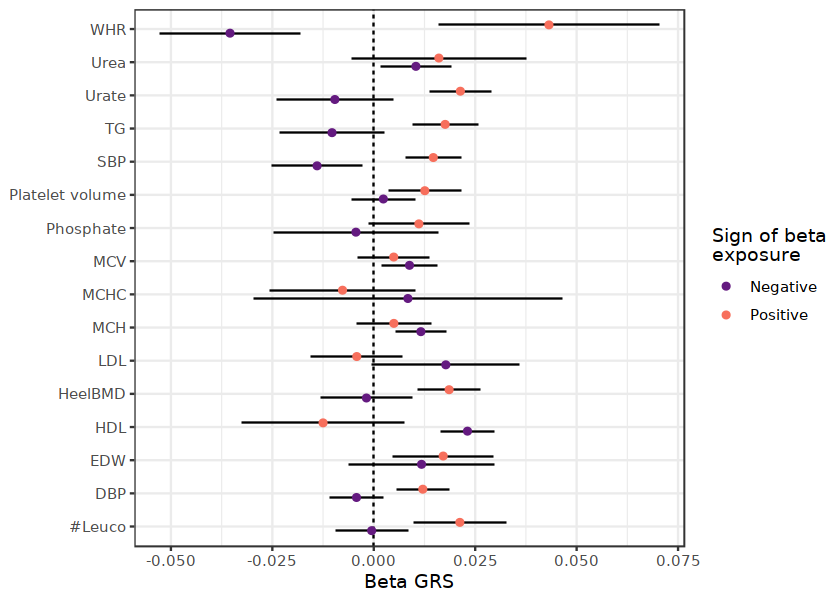

In [22]:
options(repr.plot.width = 7, repr.plot.height = 5)
instr_clinpheno_res %>%
    mutate(sign_exp = ifelse(sign_exp > 0, "Positive", "Negative")) %>%
    ggplot(aes(b_meta, trait_short)) +
    geom_vline(xintercept = 0, lty = "dashed") +
    geom_linerange(aes(xmin = conf_low_meta, xmax = conf_high_meta, group = sign_exp),
                   position = position_dodge(width = .5)) +
    geom_point(aes(group = sign_exp, color = sign_exp), position = position_dodge(width = .5)) +
    scale_color_viridis_d(begin = .3, end = .7, option = "A") +
    theme_bw() +
    labs(x = "Beta GRS", y = NULL, color = "Sign of beta\nexposure")